In [22]:
import time
import pickle
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

DIST_THRES = 10.1
MASS_PER_PARTICLE = 0.0024
MAX_FRAGMENT_SIZE = 300
n_steps = 100


def update_dynamic_mask(positions, step, vel):
    """Updates the mask based on dynamic criteria."""
    z_thres = 0 + 0.1 * (vel-2) * step
    y_min = -300 - 3 * step
    y_max = 300 + 3 * step
    
    return (positions[:, 2] > z_thres) & (positions[:, 1] > y_min) & (positions[:, 1] < y_max)


def compute_fragment_mass_kdtree(filtered_positions):
    """Computes the mass of fragments using KDTree."""
    kdt = KDTree(filtered_positions)
    indices = kdt.query_radius(filtered_positions, r=DIST_THRES)
    visited = set()
    new_fragments = []

    for idx, neighbors in enumerate(indices):
        if idx not in visited:
            new_fragment = set()
            stack = [idx]
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    new_fragment.add(current)
                    stack.extend([n for n in indices[current] if n not in visited])

            if len(new_fragment) <= MAX_FRAGMENT_SIZE:
                new_fragments.append(new_fragment)

    return sum(len(fragment) * MASS_PER_PARTICLE for fragment in new_fragments), new_fragments

all_masses = []
cases = ['d3plot2', ]
for case in cases:
    path = f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/{case}.pkl'
    try:
        with open(path, "rb") as file:
            rollout_data = pickle.load(file)
    except FileNotFoundError:
        print(f"File {path} not found.")
        continue

    pred_pos = rollout_data['pred_trajs']
    masses = np.zeros(n_steps)

    start_time = time.time()
    for step in range(n_steps):
        vel = int(case[-1])
        mask = update_dynamic_mask(pred_pos[step, :, :], step, vel)
        filtered_positions = pred_pos[step, :, :][mask]

        if filtered_positions.shape[0] > 0:
            mass, fragments = compute_fragment_mass_kdtree(filtered_positions)
            masses[step] = mass
        else:
            print(f"No particles available for computation at step {step}.")
            masses[step] = 0.0

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    all_masses.append(masses)

Elapsed time: 84.43 seconds


IndexError: list index out of range

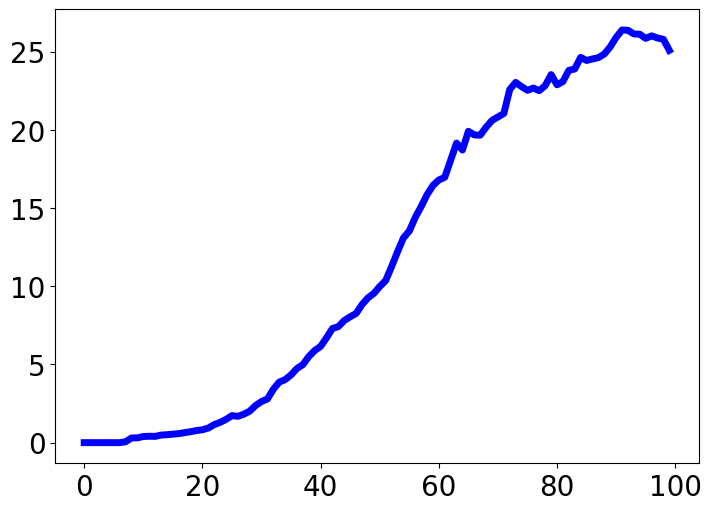

In [23]:
import matplotlib.pyplot as plt

# 2kg TNT -> 25kg fragments
# 4kg TNT -> 23kg fragments
# 6kg TNT -> 47kg fragments

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20

ax = fig.add_subplot(1, 1, 1)
ax.plot(all_masses[0], 'b')
ax.plot(all_masses[1], 'g')
ax.plot(all_masses[2], 'r')
print(all_masses[0][-1], all_masses[1][-1], all_masses[2][-1])

In [24]:
from scipy.spatial.distance import cdist

def compute_fragment_property(fragments, filtered_positions, filtered_vels):
    # Property include nparticles, diameters, velocities
    nparticles, diameters, vels = [], [], []
    
    for i, fragment in enumerate(fragments):
        fragment_positions = filtered_positions[list(fragment)]

        # calculate size (number of particles in the fragment)
        fragment_nparticle = len(fragment)

        # calculate spatial size (diameter of the fragment)
        if fragment_nparticle >= 2:  # cdist requires at least 2 points
            distances = cdist(fragment_positions, fragment_positions)
            fragment_diameter = distances.max()
        else:
            fragment_diameter = 10  # single element diameter

        # calculate fragment speed
        fragment_vels = filtered_vels[list(fragment)]
        fragment_vel = np.mean(fragment_vels, axis=0)
    
        nparticles.append(fragment_nparticle)
        diameters.append(fragment_diameter)
        vels.append(fragment_vel)
        
    # Conver list to np array
    nparticles = np.array(nparticles)
    diameters = np.array(diameters)
    vels = np.array(vels)
    
    # Sort fragments based on size
    idx = nparticles.argsort()[::-1]  # descending
    nparticles = nparticles[idx]
    diameters = diameters[idx]
    vels = vels[idx]
        
    return nparticles, diameters, vels

step = 20
mask = update_dynamic_mask(pred_pos[step, :, :], step, vel)
filtered_positions = pred_pos[step, :, :][mask]
_, fragments = compute_fragment_mass_kdtree(filtered_positions)
vels = pred_pos[step, :, :] - pred_pos[step-1, :, :]
filtered_vels = vels[mask]

_, fragment_diameters, fragment_vels = compute_fragment_property(fragments, filtered_positions, filtered_vels)
print(fragment_diameters.shape, fragment_vels.shape)

(210,) (210, 3)


In [25]:
VEL_SCALE_FACTOR = 100 / 6
vv = np.linalg.norm(fragment_vels, axis=1) * VEL_SCALE_FACTOR
np.sort(vv)[-1:].mean()

18.528595

In [27]:
pred_displacement = pred_pos[20, :, :] - pred_pos[19, :, :]
# calculate speed of each particle
pred_vel = np.linalg.norm(pred_displacement, axis=1) *VEL_SCALE_FACTOR

np.sort(pred_vel)[-20:].mean()

17.77494